In [1]:
import numpy as np                       
import pandas as pd                       
from sklearn.model_selection import train_test_split  
from sklearn.metrics import mean_squared_error        
from math import sqrt                      
import matplotlib.pyplot as plt            
from collections import defaultdict        
from sklearn.metrics.pairwise import cosine_similarity  


In [2]:
np.random.seed(42)                        
n_users = 100                              
n_items = 50                              
density = 0.12                             
n_ratings = int(n_users * n_items * density)

In [3]:
user_ids = np.random.choice(range(n_users), size=n_ratings, replace=True)
item_ids = np.random.choice(range(n_items), size=n_ratings, replace=True)
ratings = np.random.choice([1,2,3,4,5], size=n_ratings, p=[0.05,0.1,0.3,0.35,0.2])


In [4]:
df = pd.DataFrame({'user': user_ids, 'item': item_ids, 'rating': ratings})

df = df.drop_duplicates(subset=['user','item']).reset_index(drop=True)


In [7]:
for u in range(n_users):
    if (df['user'] == u).sum() < 3:
        missing = 3 - (df['user'] == u).sum()
        choices = np.random.choice(
            [i for i in range(n_items) if not ((df['user'] == u) & (df['item'] == i)).any()],
            size=missing, replace=False
        )
        df = pd.concat(
            [df, pd.DataFrame([{'user': u, 'item': it, 'rating': np.random.choice([3,4,5])}])],
            ignore_index=True
)

df = df.sample(frac=1, random_state=1).reset_index(drop=True)

print("Dataset snapshot (first 10 rows):")
print(df.head(10))

Dataset snapshot (first 10 rows):
   user  item  rating
0    70    32       3
1    25     9       4
2     0     4       2
3    86    24       3
4    86    35       5
5    68    22       2
6    68    16       4
7    73    32       5
8    89    29       5
9    19    23       3


In [8]:
train_list = []                            
test_list = []                            

for u, group in df.groupby('user'):
    if len(group) <= 2:
        train_list.append(group)           
        continue
    tr, te = train_test_split(group, test_size=0.2, random_state=42)  
    train_list.append(tr)                 
    test_list.append(te)                


In [9]:
train_df = pd.concat(train_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)

# print dataset sizes
print(f"Total ratings: {len(df)}, Train: {len(train_df)}, Test: {len(test_df)}")

Total ratings: 577, Train: 429, Test: 148


In [10]:
class MF:
    def __init__(self, n_users, n_items, n_factors=20, lr=0.01, reg=0.02, n_epochs=30):
        self.n_users = n_users           
        self.n_items = n_items            
        self.n_factors = n_factors       
        self.lr = lr                     
        self.reg = reg                    
        self.n_epochs = n_epochs          

    def fit(self, train_df, verbose=True):
        self.mu = train_df['rating'].mean()
        self.bu = np.zeros(self.n_users)
        self.bi = np.zeros(self.n_items)
        self.P = np.random.normal(scale=0.1, size=(self.n_users, self.n_factors))
        self.Q = np.random.normal(scale=0.1, size=(self.n_items, self.n_factors))

        rows = train_df[['user','item','rating']].values.astype(float)
        self.train_history = []          

        for epoch in range(self.n_epochs):
            np.random.shuffle(rows)       
            for u,i,r in rows:
                u = int(u); i = int(i)
                r = float(r)
                pred = self.predict_single(u,i)
                e = (r - pred)           
                self.bu[u] += self.lr * (e - self.reg * self.bu[u])
                self.bi[i] += self.lr * (e - self.reg * self.bi[i])
                pu = self.P[u].copy()
                qi = self.Q[i].copy()
                self.P[u] += self.lr * (e * qi - self.reg * pu)
                self.Q[i] += self.lr * (e * pu - self.reg * qi)

            preds = [self.predict_single(int(u), int(i)) for u,i,_ in rows]
            rmse = sqrt(mean_squared_error(rows[:,2].astype(float), preds))
            self.train_history.append(rmse)
            if verbose and (epoch % 5 == 0 or epoch == self.n_epochs - 1):
                print(f"Epoch {epoch+1}/{self.n_epochs} - Train RMSE: {rmse:.4f}")

        return self

    def predict_single(self, u, i):
        pred = self.mu + self.bu[u] + self.bi[i] + self.P[u].dot(self.Q[i])
        return min(5.0, max(1.0, pred))

    def predict_all_for_user(self, u):
        preds = self.mu + self.bu[u] + self.bi + self.P[u].dot(self.Q.T)
        preds = np.clip(preds, 1.0, 5.0)
        return preds


Epoch 1/30 - Train RMSE: 1.0615
Epoch 6/30 - Train RMSE: 0.9838
Epoch 11/30 - Train RMSE: 0.9334
Epoch 16/30 - Train RMSE: 0.8923
Epoch 21/30 - Train RMSE: 0.8527
Epoch 26/30 - Train RMSE: 0.8103
Epoch 30/30 - Train RMSE: 0.7728


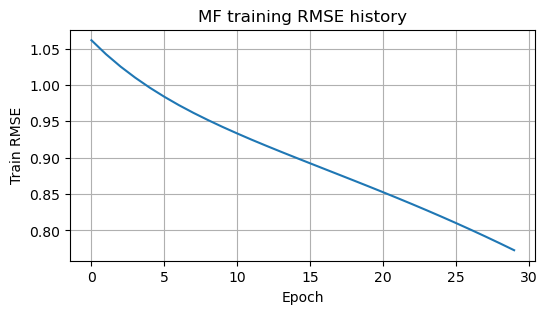

In [11]:
n_factors = 20
mf = MF(n_users=n_users, n_items=n_items, n_factors=n_factors, lr=0.01, reg=0.05, n_epochs=30)

mf.fit(train_df, verbose=True)

plt.figure(figsize=(6,3))
plt.plot(mf.train_history)
plt.xlabel("Epoch")
plt.ylabel("Train RMSE")
plt.title("MF training RMSE history")
plt.grid(True)
plt.show()


In [12]:
def evaluate_rmse(model, test_df):
    preds = []
    truths = []
    for _, row in test_df.iterrows():
        u = int(row['user']); i = int(row['item'])
        preds.append(model.predict_single(u,i))
        truths.append(row['rating'])
    rmse = sqrt(mean_squared_error(truths, preds))
    return rmse

mf_rmse = evaluate_rmse(mf, test_df)
print(f"Matrix Factorization Test RMSE: {mf_rmse:.4f}")

Matrix Factorization Test RMSE: 1.1296


In [13]:
utility = np.zeros((n_users, n_items))    
for _, row in train_df.iterrows():
    utility[int(row['user']), int(row['item'])] = row['rating']

item_sim = cosine_similarity(utility.T)    

def item_based_predict(u, i, k=10):
    user_ratings = utility[u]              
    sims = item_sim[i]                      
    rated_idx = np.where(user_ratings > 0)[0]  
    if len(rated_idx) == 0:
        global_mean = utility[utility > 0].mean() if (utility > 0).any() else 3.0
        return float(global_mean)
    sim_scores = sims[rated_idx]
    if len(sim_scores) <= k:
        topk_idx = np.argsort(sim_scores)
    else:
        topk_idx = np.argsort(sim_scores)[-k:]
    chosen_idx = rated_idx[topk_idx]        
    numer = np.dot(sim_scores[topk_idx], user_ratings[chosen_idx])  
    denom = np.sum(np.abs(sim_scores[topk_idx])) + 1e-8           
    pred = numer / denom if denom != 0 else user_ratings[user_ratings > 0].mean()
    return float(min(5.0, max(1.0, pred)))


In [14]:
ibs_preds = []
ibs_truths = []
for _, row in test_df.iterrows():
    u = int(row['user']); i = int(row['item'])
    ibs_preds.append(item_based_predict(u, i, k=10))
    ibs_truths.append(row['rating'])
item_rmse = sqrt(mean_squared_error(ibs_truths, ibs_preds))
print(f"Item-based CF Test RMSE: {item_rmse:.4f}")

Item-based CF Test RMSE: 1.5235


In [15]:
ground_truth = defaultdict(set)
for _, row in test_df.iterrows():
    if row['rating'] >= 4:
        ground_truth[int(row['user'])].add(int(row['item']))

In [16]:
train_user_items = defaultdict(set)
for _, row in train_df.iterrows():
    train_user_items[int(row['user'])].add(int(row['item']))

In [17]:
def get_top_k_mf(model, user, k=10):
    preds = model.predict_all_for_user(user)        
    seen = train_user_items[user]                   
    candidate_idx = [i for i in range(len(preds)) if i not in seen] 
    candidate_scores = preds[candidate_idx]
    top_idx_rel = np.argsort(candidate_scores)[-k:][::-1]
    top_items = [candidate_idx[i] for i in top_idx_rel]
    return top_items

In [18]:
def precision_recall_at_k(recommender_fn, K=10):
    precisions = []
    recalls = []
    for u in range(n_users):
        true_set = ground_truth.get(u, set())        
        if len(true_set) == 0:
            continue
        recommended = recommender_fn(u, k=K)        
        recommended_set = set(recommended)
        tp = len(recommended_set & true_set)          
        precisions.append(tp / K)
        recalls.append(tp / len(true_set))
    avg_prec = np.mean(precisions) if precisions else 0.0
    avg_rec = np.mean(recalls) if recalls else 0.0
    return avg_prec, avg_rec


In [20]:
def mf_recommender_fn(u, k=10):
    return get_top_k_mf(mf, u, k=k)


In [21]:
K = 10
mf_prec, mf_rec = precision_recall_at_k(mf_recommender_fn, K)
print(f"MF Precision@{K}: {mf_prec:.4f}, Recall@{K}: {mf_rec:.4f}")

MF Precision@10: 0.0268, Recall@10: 0.2136


In [22]:
def show_recommendations_for_users(users, k=10):
    for u in users:
        top_mf = get_top_k_mf(mf, u, k=k)
        print(f"\nUser {u} | MF Top-{k} recommendations: {top_mf}")
        preds = [(i, mf.predict_single(u, i)) for i in top_mf]
        print(" (item, predicted_rating):", preds)

show_recommendations_for_users(list(range(5)), k=10)


User 0 | MF Top-10 recommendations: [10, 14, 15, 26, 12, 36, 21, 32, 35, 45]
 (item, predicted_rating): [(10, np.float64(4.009238994694902)), (14, np.float64(3.869764183824386)), (15, np.float64(3.845705478049993)), (26, np.float64(3.784807003468829)), (12, np.float64(3.782469015135419)), (36, np.float64(3.729916628897447)), (21, np.float64(3.7012616775710705)), (32, np.float64(3.7002986832340437)), (35, np.float64(3.6931111773498726)), (45, np.float64(3.6847755461236114))]

User 1 | MF Top-10 recommendations: [31, 10, 14, 45, 36, 15, 32, 18, 2, 7]
 (item, predicted_rating): [(31, np.float64(4.224152789654298)), (10, np.float64(4.214768420256947)), (14, np.float64(4.057014648855423)), (45, np.float64(3.9850496157592583)), (36, np.float64(3.974753895834386)), (15, np.float64(3.965936413234074)), (32, np.float64(3.9423462916228282)), (18, np.float64(3.940920235461974)), (2, np.float64(3.878336719648141)), (7, np.float64(3.8173724430494786))]

User 2 | MF Top-10 recommendations: [31, 14,